# Configuración del entorno virtual del proyecto:

* Instalemos el paquete python3-venv que proporciona el módulo venv.
``sudo apt install python3-venv``
* Dentro del directorio donde le gustaría almacenar sus entornos virtuales de Python 3 ejecutamos el comando siguiente para crear su nuevo entorno virtual con nombre ``venv``:
``python3 -m venv venv``
* Para comenzar a usar este entorno virtual, debe activarlo ejecutando el script de activación
``source venv/bin/activate``
* Una vez que hemos terminado con el desarrollo del trabajo para desactivar el entorno y volver al shell normal, ejecutamos:
``deactivate``


In [23]:
# Manejo de archivos
import pandas as pd
# Calculos numericos/matemáticos
import numpy as np
# Visualizacion
import seaborn as sns
import matplotlib.pyplot as plt
# Modelos matematicos ML
from scipy import stats
# EDA
import missingno as msno

pd.set_option('display.max_columns', None)
pd.set_option('display.max.rows', 90)

In [24]:
# Cargamos los datasets .CSV
test = pd.read_csv('./properties_colombia_test.csv', index_col=False)
train = pd.read_csv('./properties_colombia_train.csv', index_col=False)

In [25]:
# Se alimina las columna 'Unnamed: 0' de los datasets porque son columnas que no son de nuestro interés
test = test.drop(columns=['Unnamed: 0'])
train = train.drop(columns=['Unnamed: 0'])

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197549 entries, 0 to 197548
Data columns (total 26 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               197549 non-null  object 
 1   ad_type          197549 non-null  object 
 2   start_date       197549 non-null  object 
 3   end_date         197549 non-null  object 
 4   created_on       197549 non-null  object 
 5   lat              148051 non-null  float64
 6   lon              148051 non-null  float64
 7   l1               197549 non-null  object 
 8   l2               197549 non-null  object 
 9   l3               186517 non-null  object 
 10  l4               45367 non-null   object 
 11  l5               27409 non-null   object 
 12  l6               6867 non-null    object 
 13  rooms            27537 non-null   float64
 14  bedrooms         40525 non-null   float64
 15  bathrooms        156467 non-null  float64
 16  surface_total    6974 non-null    floa

### ``Columnas: start_date - end_date - created_on``

*Consistencia de datos de tiempo*

In [27]:
# TRAIN

# Tranformacion de datos a datetime
train['start_date'] = pd.to_datetime(train['start_date'], format='%Y-%m-%d')
# 
train['created_on'] = pd.to_datetime(train['created_on'], format='%Y-%m-%d')
# 
train['end_date'] = train.end_date.replace('9999-12-31', '2021-12-31')
train['end_date'] = pd.to_datetime(train['end_date'], format='%Y-%m-%d')

# FUNCION
# dt_columns = ['start_date','end_date','created_on']
# def to_datetime(lst):
#     for i in range(len(lst)):
#         train[lst[i]] = pd.to_datetime(train[lst[i]], format='%Y-%m-%d')
#     return train
# train = to_datetime(dt_columns)


### ``Columnas: lat - lon - l1 - l2 - l3 - l4 - l5 - l6``

### ``Columnas: rooms - bedrooms - bathrooms``

EXisten **170008 valores nulos** dentro de la columna ``rooms`` que representan el 86.06% de los datos de dicha columna, la suma de valores nulos es significativo por ello la elección de aliminarlos se descarta de nuestra posibilidad. La lógica plasmada a la realidad nos conduce a plantear dos situaciones, una primera que se estaría ofreciendo quizá unicamente terreno en metros cuadrados como inmueble u otra segunda donde probablemente se esté ofreciendo ``bedrooms`` y ``bathrooms`` únicamente como inmueble. Para nuestro caso particular priorizaremos siempre quedarnos con la mayor cantidad de datos posible sin entrar en mayor detalle, por ende asumiremos que estamos en la segunda situación.
Para completar lo valores nulos verificaremos la columnas bredrooms y bathrooms, vamos a asumir que la cantidad mínima de ambientes (rooms) será la suma ``bathrooms`` y ``bedrooms``.

In [153]:
train['rooms'].isna().sum()
total_rooms = train['rooms'].shape[0]
nan_rooms = train['rooms'].isna().sum()
per_nan_roms = (nan_rooms/total_rooms)*100
print(f'Porcentaje de valores nulos en la columna rooms: {round(per_nan_roms,2)}')
# train['rooms'].unique()

Porcentaje de valores nulos en la columna rooms: 0.0


In [28]:
# Complatamos los valores nulos por el valor cero
train[['rooms', 'bedrooms', 'bathrooms']] = train[['rooms', 'bedrooms', 'bathrooms']].fillna(0)
# Parseamos las variables a entero (int64)
train[['rooms', 'bedrooms', 'bathrooms']] = train[['rooms', 'bedrooms', 'bathrooms']].astype('int64')

In [29]:
# Sumamos la columna bedrooms y bathrooms para completar los valores nulos que fueron reemplazados por el valor 0 ateriormente en el parseo.
# Si el valor de rooms es igual a cero se completa con la suma mencionada y caso contrario se completa con el valor existente de rooms

train['rooms'] = train[['bedrooms','bathrooms']].sum(axis=1).where(train['rooms'] == 0,train['rooms'])

# train_sample['rooms'] = train_sample[['bedrooms','bathrooms']].sum(axis=1).where(train_sample['rooms'] == 0,train_sample['rooms'])

In [30]:
# Verificamos los valores únicos de la columna rooms
num_rooms_cero = train[train['rooms'] == 0].shape[0]
total_rooms = train['rooms'].shape[0]
perc_rooms_cero = (num_rooms_cero/total_rooms)*100
print(f'Porcentaje de rooms con valor cero: {round(perc_rooms_cero,1)}%')

Porcentaje de rooms con valor cero: 11.4%


Podemos observar que seguimos obteniendo un valor cero como el numero de habitaciones (rooms). Esto podría signifcar que probablemente solo se está ofreciendo terreno (en metros cuadrados) o es un registro que debería volver a la etapa de ETL y verificar si esto es realmente así. Para nuestro caso consideraremos que la presencia del valor cero en rooms sigue considerandose un inmueble por la representatividad que tienen dentro del ocnjunto de datos (representan un 11.4% de datos de la columna rooms).

#### ``Columnas: surface_total - surface_covered``

In [31]:
# Verificacion de valores nulos
total_surface = train['surface_total'].shape[0] # 197549
# total_surface
nan_total_surface = train['surface_total'].isna().sum() # 190575
# nan_total_surface
perc_nan_ts = (nan_total_surface / total_surface)*100
print(f'Procentaje de valroes nulos en la columna surface_total: {round(perc_nan_ts,1)}%')

Procentaje de valroes nulos en la columna surface_total: 96.5%


In [213]:
# Verificacion de valores nulos
total_surface_covered = train['surface_covered'].shape[0] # 197549
# print(total_surface)
nan_surface_covered = train['surface_covered'].isna().sum() # 190575
# print(nan_total_surface)
perc_nan_sc = (nan_surface_covered / total_surface_covered)*100
print(f'Procentaje de valores nulos en la columna surface_covered: {round(perc_nan_sc,1)}%')

Procentaje de valores nulos en la columna surface_covered: 95.0%


Nuestra propuesta para resolver los casos de valores nulos en la columna `surface_total` es *inputarlos* con la media o mediana, para ello averiguemos que tan representativos son cada uno de estos estadíticos.

In [226]:
# Filtro/mascara que no considera los valores nulos o del tipo nan
mask = ~(train['surface_total'].isna())

# Media de los valores de superficie total con el filtro
media_st = train[mask]['surface_total'].mean()

# Mediana de los valores de superficie total con el filtro
mediana_st = train[mask]['surface_total'].median()

print(f'Promedio de los valores de superficie total: {media_st}')
print(f'Mediana de los valores de superficie total: {mediana_st}')

Promedio de los valores de superficie total: 1352.1323487238315
Mediana de los valores de superficie total: 120.0


Como la media y mediana de los valores de superficie total tienen una diferencia considerable, optaremos por elegir el valor de la mediana para no conservar la tendencia central porque estamos ante un caso de distribución sesgada.

In [227]:
# Filtro/mascara que no considera los valores nulos o del tipo nan
mask = ~(train['surface_total'].isna())
# Reemplazando los valores nulos (nan) por la mediana del conjunto de valroes existentes
train['surface_total'] = train['surface_total'].fillna(train[mask]['surface_total'].median())

#### ``Columnas: currency - price_period``

Consultando la plataforma [globocambio.co](https://www.globocambio.co/es/inicio) el valor del dolar a cambio de pesos colombianos se tiene que **$ 5 = COP 24.700,01**

![](cambio_dolares_pesos.png)

In [382]:
# Cambio de dólares (USD) a pesos colombianos (COP)
train['price'] = np.where(train['currency']=='USD', (train['price']*24700.01)/5, train['price'])


KeyboardInterrupt



#### ``Columna: Price``

Se pudieron encontrar **cuatro** registros con valores **cero** en la columna `price`. El registro de los precios de venta de estos inmuebles probablemnete tengan otro tratamiento, otro tipo de contrato, o incluso podría tratarse de una situación de estafa, por tal motivo procederemos a eliminar los registros cuyo valor sea **cero**, los **nan** los reemplazamos con el valor de la **mediana** para no perder datos.

**Tratamiento de datos con valor cero**

In [34]:
# Verificacion de valores nulos
mask = train['price'] == 0
cero_price = train[mask].shape[0]
print(f'Cantidad de registros de precio con valor cero: {cero_price}')

Cantidad de registros de precio con valor cero: 4


In [64]:

# Eliminamos los registros donde el valor del precio sea cero
mask = train['price'] == 0
train = train[~mask]

**Tratamiento de valores nulos**

In [36]:
# Nulos en columna price/precios
train['price'].isna().sum()

# Reemplazamos con la mediana de los precios para no alterar
train['price'] = train['price'].fillna(train['price'].median())

In [37]:
# Funcion que categoriza en 'costoso' o 'barato' segun el precio limite (precio promedio)

def esCostoso(precio):
    media = train['price'].mean()
    if precio >= media:
        return 'costoso'
    elif (precio < media) & (precio > 0):
        return 'barato'
    
train['target'] = train['price'].map(esCostoso, na_action='ignore')

#### ``Columnas: title -description``

In [144]:
nan_title = train['title'].isna().sum()
print(f'Valores nulos/nan en la columna title: {nan_title}')

Valores nulos/nan en la columna title: 1


In [145]:
nan_description = train['description'].isna().sum()
print(f'Valores nulos/nan en la columna description: {nan_description}')

Valores nulos/nan en la columna description: 121


#### ``Columnas: property_type - operation_type``

In [146]:
prop_types = train['property_type'].unique()
print(f'Los tipos de propiedades son: {str(prop_types).replace("[","").replace("]","")}')

Los tipos de propiedades son: 'Casa' 'Apartamento' 'Otro' 'Oficina' 'Finca' 'Lote' 'Local comercial'
 'Parqueadero'


#### ``Columnas: geometry``

In [150]:
train['geometry'].unique()

array(['POINT (-75.572 6.203)', 'POINT (-74.0731146 4.7227485)',
       'POINT (-74.03 4.709)', ..., 'POINT (-75.5673540104 6.1719703075)',
       'POINT (-75.7585776037 4.8321104685)', 'POINT (-73.106 7.064)'],
      dtype=object)

In [152]:
nan_geometry = train['geometry'].isna().sum()
print(f'La cantidad de valores nulos de la columna geometry es: {nan_geometry}')

La cantidad de valores nulos de la columna geometry es: 0


### ``Preprocesamiento e Ingeniería de Características``

In [156]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197545 entries, 0 to 197548
Data columns (total 27 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   id               197545 non-null  object        
 1   ad_type          197545 non-null  object        
 2   start_date       197545 non-null  datetime64[ns]
 3   end_date         197545 non-null  datetime64[ns]
 4   created_on       197545 non-null  datetime64[ns]
 5   lat              148051 non-null  float64       
 6   lon              148051 non-null  float64       
 7   l1               197545 non-null  object        
 8   l2               197545 non-null  object        
 9   l3               186513 non-null  object        
 10  l4               45367 non-null   object        
 11  l5               27409 non-null   object        
 12  l6               6867 non-null    object        
 13  rooms            197545 non-null  int64         
 14  bedrooms         197

In [164]:
train['property_type'].unique()

array(['Casa', 'Apartamento', 'Otro', 'Oficina', 'Finca', 'Lote',
       'Local comercial', 'Parqueadero'], dtype=object)

In [168]:
from sklearn import preprocessing

# Instaciamos el preprocesador LabelEncoder
le = preprocessing.LabelEncoder()

# Aplicamos la transformación
train['property_type'] = le.fit_transform(train['property_type'])

In [190]:
unique_prop_type = train['property_type'].unique()
unique_prop_type_le = le.inverse_transform(unique_prop_type)
print(f'Tipo de propiedad encondeado: {str(unique_prop_type).replace("[","").replace("]","")}')
print(f'Tipo de propiedad sin encondear: {str(unique_prop_type_le).replace("[","").replace("]","")}')

Tipo de propiedad encondeado: 1 0 6 5 2 4 3 7
Tipo de propiedad sin encondear: 'Casa' 'Apartamento' 'Otro' 'Oficina' 'Finca' 'Lote' 'Local comercial'
 'Parqueadero'


#### ``Columna: target``

In [234]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

train['target'] = le.fit_transform(train['target'])

In [237]:
# Verificacion y correspondencia de clases
unique_target_val = train['target'].unique()
print('Valores unicos:',unique_target_val)
print('Valores transformados unicos:',le.inverse_transform(unique_target_val))
# 1:costoso
# 0:barato

Valores unicos: [1 0]
Valores transformados unicos: ['costoso' 'barato']


## **1. Árbol de decisión**

Ahora que tenemos nuestras variables predictoras `X`, por un lado, y nuestra varible a predecir `y`, por el otro, vamos a crear un modelo de árbol de decisión.

Recordemos el flujo de trabajo de ML en Scikit-Learn: creamos el modelo / entrenamos / predecimos.

In [242]:
# Selección de las columnas que vamos a usar para el proceso de entrenamiento del modelo
train_sample = train[['rooms','bedrooms','bathrooms','price','property_type', 'surface_total','target']].copy(deep=True)
# Reindexación del nuevo dataframe
train_sample.reset_index(drop=True, inplace=True)


In [276]:
X = train_sample[['rooms','bedrooms','bathrooms','property_type', 'surface_total']]
y = train_sample['target']

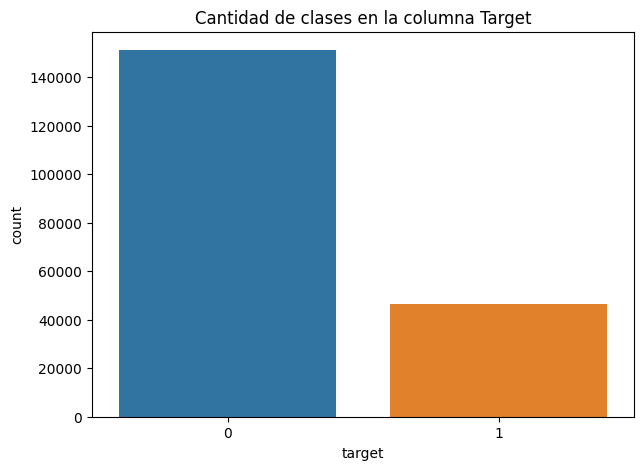

In [288]:
plt.figure(figsize=(7,5))
plt.title('Cantidad de clases en la columna Target')
sns.countplot(x='target', data=train_sample)
plt.show()

In [278]:
# Variables predictoras y separacion de datos en entrenamiento y testeo
from sklearn.model_selection import train_test_split

# Separacion considerando 20% para el test
# el método train_test_split devuelve subconjuntos de entrenamiento y prueba que tendrán las mismas proporciones de etiquetas de clase que el conjunto de datos de entrada.
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42, stratify=y)

Entrenamiento del modelo y evaluación

In [285]:
# Importamos el modelo de Arbol de Decisión
from sklearn.tree import DecisionTreeClassifier

# Creamos un objeto arbol
tree = DecisionTreeClassifier(max_depth=10)

In [286]:
# Entrenar el modelo
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10)

Mértrica de Evaluacion de modelos de clasificación

In [287]:
from sklearn.metrics import accuracy_score

# Predecimos sobre nuestro set de entrenamieto
y_train_pred = tree.predict(X_train)

# Predecimos sobre nuestro set de test
y_test_pred = tree.predict(X_test)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred,y_test))

Accuracy sobre conjunto de Train: 0.8236224657672935
Accuracy sobre conjunto de Test: 0.8220911691007112


In [372]:
def ajuste_arbol_decision(num):
    # Importamos el modelo de Arbol de Decisión
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.metrics import accuracy_score

    # Variables predictoras y separacion de datos en entrenamiento y testeo
    from sklearn.model_selection import train_test_split

    # Separacion considerando 20% para el test
    # el método train_test_split devuelve subconjuntos de entrenamiento y prueba que tendrán las mismas proporciones de etiquetas de clase que el conjunto de datos de entrada.
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42, stratify=y)

    lst_acc_train = []
    lst_acc_test = []
    for i in range(1,num):    
        # Creamos un objeto arbol
        tree = DecisionTreeClassifier(max_depth=i)
        
        # Entrenar el modelo
        tree.fit(X_train, y_train)
        
        # Predecimos sobre nuestro set de entrenamieto
        y_train_pred = tree.predict(X_train)

        # Predecimos sobre nuestro set de test
        y_test_pred = tree.predict(X_test)
        
        lst_acc_train.append(accuracy_score(y_train_pred,y_train))
        lst_acc_test.append(accuracy_score(y_train_pred,y_train))
    
    lst_acc_test = pd.Series(lst_acc_test).T
    lst_acc_train = pd.Series(lst_acc_train).T
    # df = pd.DataFrame(data=[[pd.Series(lst_acc_train),pd.Series(lst_acc_test)]], columns=['train_accuracy', 'test_accuracy'])
    # df = pd.DataFrame(data=[lst_acc_train,lst_acc_test], columns=['train_accuracy', 'test_accuracy'])
    df = pd.DataFrame(data=[lst_acc_train, lst_acc_test], index=['train_accuracy', 'test_accuracy']).T
    return df
    # return lst_acc_test

    # # Comaparamos con las etiquetas reales
    # print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred,y_train))
    # print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred,y_test))    

In [375]:
df_arbol_decision = ajuste_arbol_decision(80)

In [378]:
df_arbol_decision['test_accuracy'].min(), df_arbol_decision['test_accuracy'].max() # N°  (0.807356035897918, 0.8264403641859691)

(0.807356035897918, 0.8264403641859691)

### ``SelectKBest``

Mediante la función SelectKBest de ScikitLearn, detectar los features más relevantes del dataset provisto

In [ ]:
# Apilamos los datasets / Union por rows
# df0 = pd.concat([train, test], axis=0).reset_index(drop=True)
# df0.head(1)

In [273]:
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197545 entries, 0 to 197544
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   rooms          197545 non-null  int64  
 1   bedrooms       197545 non-null  int64  
 2   bathrooms      197545 non-null  int64  
 3   price          197545 non-null  float64
 4   property_type  197545 non-null  int64  
 5   surface_total  197545 non-null  float64
 6   target         197545 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 10.6 MB


In [274]:
sns.pairplot(train_sample, hue="target")
plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f2467000790> (for post_execute):


KeyboardInterrupt: 